In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")
# pd.options.display.float_format = '{:.4%}'.format

In [2]:
df = pd.read_csv('./data/stocks.csv',index_col='date',parse_dates=True)

In [3]:
df

,000338.SZ,002027.SZ,002371.SZ,600009.SH,600029.SH,600183.SH,600406.SH,600900.SH,601989.SH,601998.SH
date,,,,,,,,,,
2010-03-16,4.6699,1.4920,12.3653,15.0836,5.9234,3.5885,3.1943,4.9168,4.0047,3.7238
2010-03-17,4.7768,1.5237,12.4617,15.6086,6.0735,3.7430,3.2822,4.9748,4.0699,3.8038
2010-03-18,4.7267,1.5395,12.3046,15.5336,6.0999,3.7499,3.2873,4.9439,4.0403,3.7825
2010-03-19,4.7462,1.5440,11.6570,15.7252,6.3559,3.9353,3.3255,4.9439,4.0640,3.7985
2010-03-22,4.8291,1.5712,11.8058,15.7919,6.3736,4.0692,3.4516,4.9323,4.1291,3.8359
...,...,...,...,...,...,...,...,...,...,...
2024-09-23,12.6100,5.5044,283.8600,31.0200,5.2800,16.7300,25.6400,28.2000,4.4900,6.0100
2024-09-24,12.9900,5.7797,295.0900,32.2800,5.4800,17.5600,25.6900,28.7600,4.6400,6.2900
2024-09-25,13.1300,5.7600,294.7000,32.5000,5.6200,17.5400,26.4700,28.9300,4.8800,6.4000


# 初始化相关变量

In [4]:
# 设置数据的计算窗口（工作日数量），每年工作日数量：252
windows = 252
# 设置回测窗口数量
backtest_T = 128

# 设置保存权值的容器
opt_W = pd.DataFrame(data=None)

# 单个资产交易成本率
cost = 0.0025

# 各资产收益率矩阵计算

In [5]:
data = np.log(df/df.shift()) # 计算收益率
data.dropna(inplace=True)

In [6]:
idx = data.index.get_loc('2023-08-07') #根据DRL回测的结果，确定要回测的数据起始日期索引
data.index[idx] 

Timestamp('2023-08-07 00:00:00')

In [7]:
data_backtest = data[idx:idx+backtest_T] #确定收益率的回测区间

# 计算通过CVaR优化后的权值

In [8]:
import riskfolio as rp

for i in range(backtest_T-1):  # 最后一天不作交易，所以少一天，则预测的天数为：backtest_T - 1 
    Y = data[idx-windows+i:idx+i]
    
    # Building the portfolio object
    port = rp.Portfolio(returns=Y)

    # Calculating optimal portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Estimate optimal portfolio:

    model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = 'CVaR' # Risk measure used,'MV','CVaR', 'EVaR' etc.
    obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate
    l = 0 # Risk aversion factor, only useful when obj is 'Utility'

    w_cvar = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)    
    
    opt_W = pd.concat([opt_W,w_cvar.T],axis=0)

In [9]:
opt_W.columns = opt_W.columns.map(lambda x: 'w_'+ x)
opt_W.index = data[idx+1:idx+1+backtest_T-1].index # 计算出来的权重滞后一天，所以要从idx+1开始

# 交易成本计算

In [10]:
# 计算相对价格向量Yt
Y_t = df / df.shift()
Y_t.dropna(inplace=True)
Y_t.index[idx]

Timestamp('2023-08-07 00:00:00')

In [11]:
Y_t = Y_t[idx+1:idx+1+backtest_T]
Y_t['CASH'] = 1 #增加现金的相对价格向量

计算t-1时刻的权重矩阵

In [12]:
# 为优化后的opt_W插入初始权重值0，变为W_0,即论文中的Wt-1
inserted_zero = pd.DataFrame(np.zeros(opt_W.shape[1]))
inserted_zero = inserted_zero.T
inserted_zero.columns = opt_W.columns

W_0 = pd.concat([inserted_zero, opt_W],axis=0)

In [13]:
# 给W_0增加无风险资产的权重值，即现金权值
W_0.index = data[idx:idx+backtest_T].index
W_0['w_CASH'] = 0
W_0['w_CASH'][0] = 1 # 现金只在最初时持有

计算权值W_，即论文中的W'

In [14]:
# 计算随着价格变动后的资产权值 W_ (即论文公式中的W')
W_ = Y_t.values * W_0.values / (Y_t.values * W_0.values).sum(1)[:,None]

计算t时刻的权重矩阵

In [15]:
# 因为回测的最后一天不交易，所以把W_中最后一行的权重值插到opt_W尾部，形成t时刻的权重矩阵W_1，即论文中的Wt
inserted_lastweight = W_[-1,:]
inserted_lastweight = pd.DataFrame(inserted_lastweight)
inserted_lastweight = inserted_lastweight.T
inserted_lastweight.columns = W_0.columns 

In [16]:
W_1 = pd.concat([opt_W,inserted_lastweight],axis=0)
W_1.index = data[idx+1:idx+1+backtest_T].index

计算投资组合的交易成本率

In [17]:
C_t = cost * (np.abs(W_ - W_1).sum(1))

<Axes: xlabel='date'>

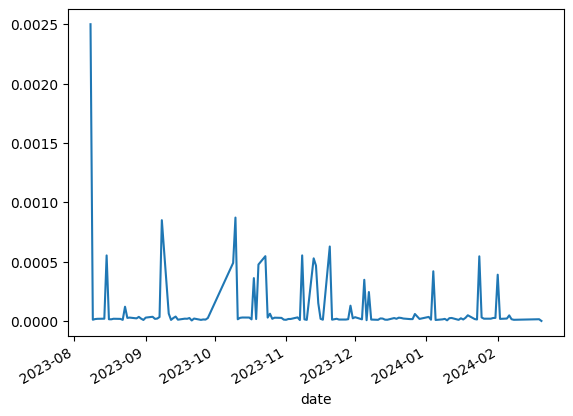

In [18]:
C_t.plot()

In [19]:
C_t.to_csv('./data/temp/forStocks/costs/Costs_CVaR_MinRisk.csv')

# 投资组合价值计算

In [20]:
# 计算投资组合的收益率R_t
R_t = np.log(1-C_t.values) + (np.log(Y_t.values) * W_0.values).sum(1)

In [21]:
R_t = pd.DataFrame(R_t)
R_t.index = Y_t.index

In [22]:
# R_t.plot()

In [23]:
# 把投资组合收益率转为资产价格
price = np.exp(R_t.cumsum())
price.rename(columns={0:'CVaR_MinRisk'},inplace=True)

<Axes: xlabel='date'>

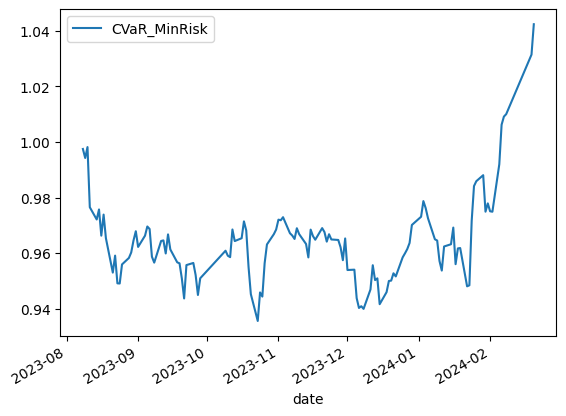

In [24]:
price.plot()

In [25]:
price.to_csv('./data/temp/forStocks/values/Values_CVaR_MinRisk.csv')

# 其它

In [26]:
W_0.sort_index(axis=1,inplace=True)

<Axes: xlabel='date'>

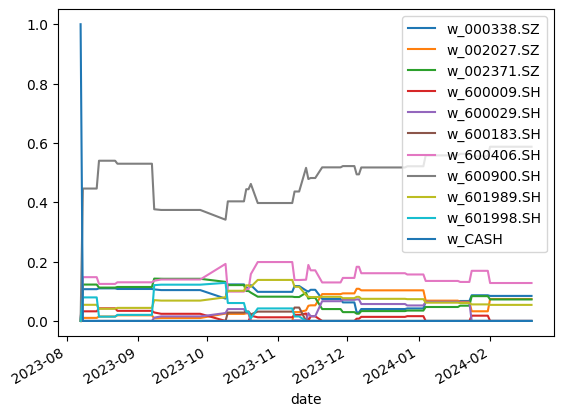

In [27]:
W_0.plot()

In [28]:
W_0.to_csv('./data/temp/forStocks/weights/Weights_CVaR_MinRisk.csv') 

In [29]:
from util import sharpe, sortino, MDD, MDD1, calmar, other_metrics

In [30]:
print("每日平均收益率(log return)：",np.mean(R_t.values))

每日平均收益率(log return)： 0.0003242656254730854


In [31]:
print('年化sharpe比率:',sharpe(R_t.values)) 

年化sharpe比率: 0.7073852494743017


In [32]:
print('年化sortino比率：',sortino(R_t.values))

年化sortino比率： 1.131201649836782


In [33]:
print('最大回撤',MDD1(price['CVaR_MinRisk']))

最大回撤 0.06266619792053119


In [34]:
print('Calmar比率:',calmar(R_t.values))

Calmar比率: 1.3039715242153762


In [35]:
other_metrics(R_t.values)

平均年化收益率（annual average return）： 0.08171493761921753
年化波动率（annual variance）： 0.1155152934566744
投资胜率（percentage of positive trade returns）： 0.515625
平均益损比（ratio between positive and negative returns）: 1.0566467794741392
